In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import img_as_float
from skimage.exposure import cumulative_distribution 

%matplotlib inline

In [5]:
def plot_image(images, titles=None, cmap=None):
    
    if isinstance(images, list) or isinstance(images, tuple):
        pass
    else:
        images = [images]
    
    n_images = len(images)
    
    fig = plt.figure(figsize=(6 * n_images, 6))
    
    for i, image in enumerate(images):
        axis = fig.add_subplot(1, n_images, 1+i)
    
        # If we have a colour image, do not specify a colormap
        if image.ndim == 3:
            if titles is not None:
                title = titles[i]
            else:
                title = 'Colour image of shape {}'.format(image.shape)
            axis.imshow(image)
        else:
            if titles is not None:
                title = titles[i]
            else:
                title = 'Greyscale image of shape {}'.format(image.shape)
            # Else, use the colormap supplied
            if cmap is not None:
                axis.imshow(image, cmap=cmap)

            # Else use a default black and white colourmap
            else:
                axis.imshow(image, cmap=plt.cm.gray)
        
        # Remove the axes and use a tight layout
        axis.set_title(title)
        axis.set_axis_off()
        
    fig.tight_layout()
    
    # Display the image
    plt.show()


def plot_image_and_hist(images, titles, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    
    n_images = len(images)
    
    # Display results
    fig = plt.figure(figsize=(4 * n_images, 8))
    axes = np.zeros((2, n_images), dtype=np.object)
    
    for i in range(n_images):
        
        if i == 0:
            axes[0, i] = fig.add_subplot(2, n_images, 1)
        else:
            axes[0, i] = fig.add_subplot(2, n_images, 1+i, sharex=axes[0,0], sharey=axes[0,0])

        axes[1, i] = fig.add_subplot(2, n_images, n_images+1+i)
    
    for i, image in enumerate(images):

        image = img_as_float(image)
            
        ax_img, ax_hist = axes[:, i]
        ax_cdf = ax_hist.twinx()
            
        ax_img.set_title(titles[i])
        ax_img.imshow(image, cmap=plt.cm.gray)
        ax_img.set_axis_off()

        # Display histogram
        ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
        ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
        ax_hist.set_xlabel('Pixel intensity')
        ax_hist.set_xlim(0, 1)
        ax_hist.set_yticks([])
        
        if i == 0:
            y_min, y_max = ax_hist.get_ylim()
            ax_hist.set_ylabel('Number of pixels')
            ax_hist.set_yticks(np.linspace(0, y_max, 5))
        
        # Display cumulative distribution
        img_cdf, bins = cumulative_distribution(image, bins)
        ax_cdf.plot(bins, img_cdf, 'r')
        ax_cdf.set_yticks([])
    
    ax_cdf.set_ylabel('Fraction of total intensity')
    ax_cdf.set_yticks(np.linspace(0, 1, 5))

    # prevent overlap of y-axis labels
    fig.tight_layout()
    plt.show()

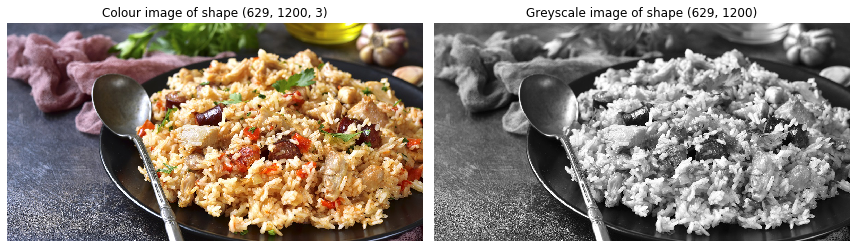

In [112]:
from skimage.io import imread
from skimage.color import rgb2gray

image = imread("../../data/images/2/000003")
grayscale = rgb2gray(image)

plot_image([image, grayscale])

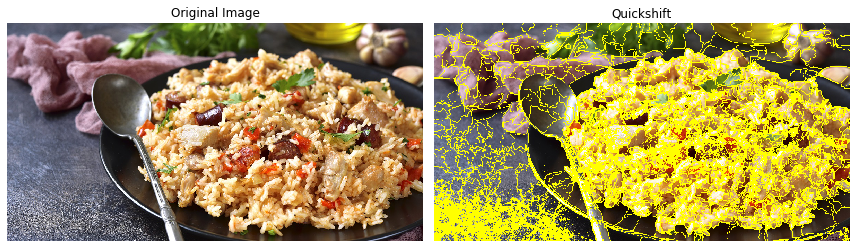

In [133]:
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries

segments_quickshift = quickshift(image, kernel_size=10, max_dist=6, ratio=1.0)
segments_fz = felzenszwalb(image, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(image, n_segments=30, compactness=10, sigma=1)

plot_image([image, mark_boundaries(image, segments_quickshift)],
          ['Original Image', 'Quickshift'])

## Segmentation

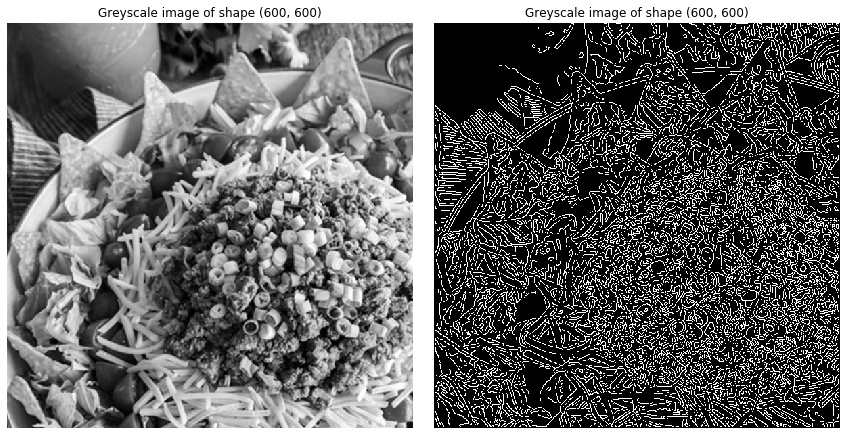

In [105]:
from skimage.feature import canny
# Use the skimage.feature.canny fucntion to identify edges in our grayscale
# image - play about with the value of Gaussian sigma to see how this affects the outcome
canny_edges = canny(grayscale, sigma=0.8)

plot_image([grayscale, canny_edges])

After identifying edges, we can fill in the areas between them to create binary regions.

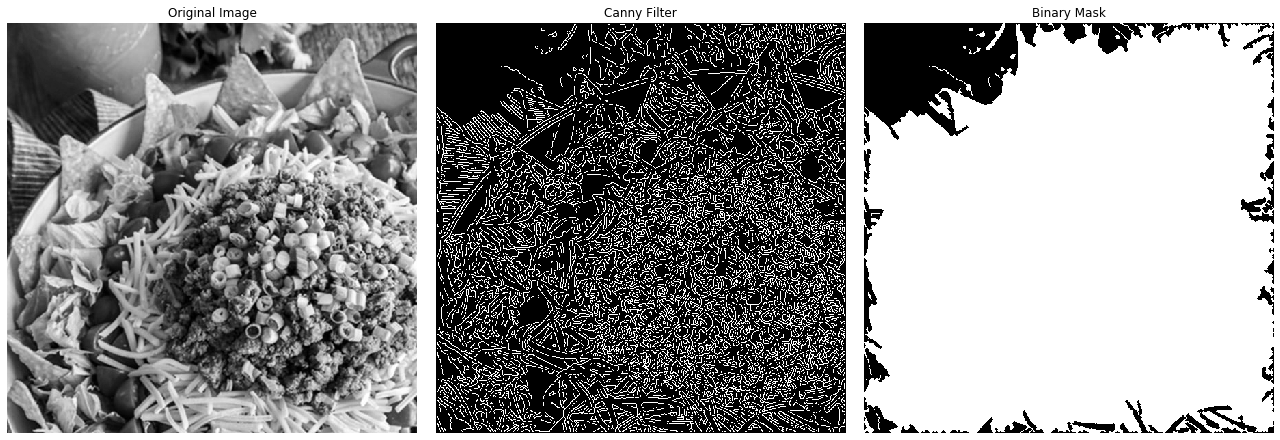

In [106]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import binary_closing
from skimage.morphology import disk


closed = binary_closing(canny_edges, selem=disk(2))

binary_mask = binary_fill_holes(closed)

plot_image([grayscale, canny_edges, binary_mask],
          ['Original Image', 'Canny Filter', 'Binary Mask'])

The `skimage.measure.label` algorithm can then be used to label each connected region in a binary image. It returns a new array with an integer label for each pixel in the image representing the segement that it belongs to. Each segment is made up from pixels containing a binary value of 1 that are connected together spatially. The distance with which pixels are connected and therefore considered 'neighbours' can be altered using the `connectivity` keyword argument.

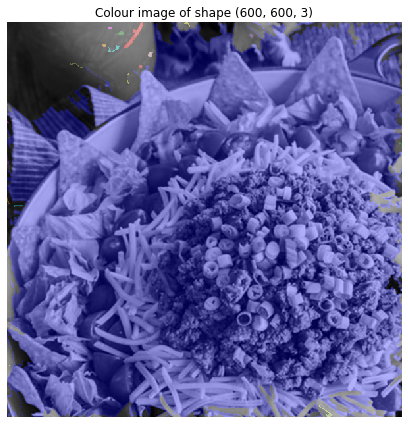

In [107]:
from skimage.measure import label
from skimage.color import label2rgb
# Apply the skimage.measure.label algorithm to oour binary_mask. Experiement
# with varying the value of the connectivity keyword argument to form labelled segments

label_image = label(binary_mask)

image_label_overlay = label2rgb(label_image, image=grayscale, bg_label=0)

plot_image(image_label_overlay)

This is a typical method to segment regions in images. Once a label image has been created, the `skimage.measure.regionprops` algorithm can be used to create a list of `RegionProperties` objects representing each segment. These objects have attributes providing metrics to describe the segment's content, size and shape. The keyword argument `intensity_image` can also be used to provide the original image as a reference.

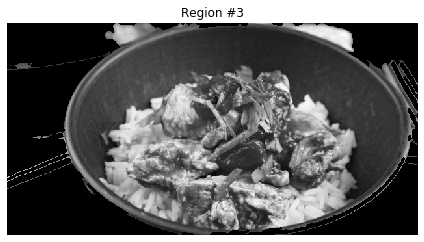

In [69]:
from skimage.measure import regionprops
# Apply the skimage.measure.regionprops algorithm to the label_image array
# in order to extract a list of RegionProperties object describing each segment.

regions = regionprops(label_image, intensity_image=grayscale)

regions = [region for region in regions if region.area > 3000]

plot_image([region.intensity_image for region in regions],
           [f'Region #{region.label}' for region in regions])

## Color Based Segmentation

Assuming that the color in stained microscope slides is relatively consistent, we can also attempt to cluster each pixel in an RGB image by its hue (unit RGB vector).

This can be performed by using machine learning clustering algorithims supplied in the scikit-images library. Alternatively, scikit-image has some inbuilt tools to provide assistance for certain microscope stain patterns. The `skimage.color.seperate_strains` function contains many different conversion options to transform each channel into weightings representing the concentration of dye in each color stain.

This conversion is performed as a matrix multiplication of each RGB vector with the generic form shown below, that is derived from the Beer-Lambert Law describing intensity of light from chemical concentrations. Here we represent our RGB image as $\mathbf{I}(x, y)$, since we now possess a vector for each pixel, and our conversion operation $\mathbf{A}$ is a normalised 3 x 3 matrix.

$\mathbf{G}(x, y) = -  \mathbf{A}\log{\left(\mathbf{I}(x, y)\right)}$

Conversions for microscope stains currently included in scikit-image include:

1. Hematoxylin + Eosin + DAB
2. Hematoxylin + DAB
3. Feulgen + Light Green
4. Giemsa stain : Methyl Blue + Eosin
5. FastRed + FastBlue +  DAB
6. Methyl Green + DAB
7. Hematoxylin + AEC
8. Blue matrix Anilline Blue + Red matrix Azocarmine + Orange matrix Orange-G
9. Methyl Blue + Ponceau Fuchsin
10. Alcian Blue + Hematoxylin
11. Hematoxylin + PAS

/Users/mczech/.local/share/virtualenvs/pydata_tutorial-0ovqeyxF/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  # This is added back by InteractiveShellApp.init_path()


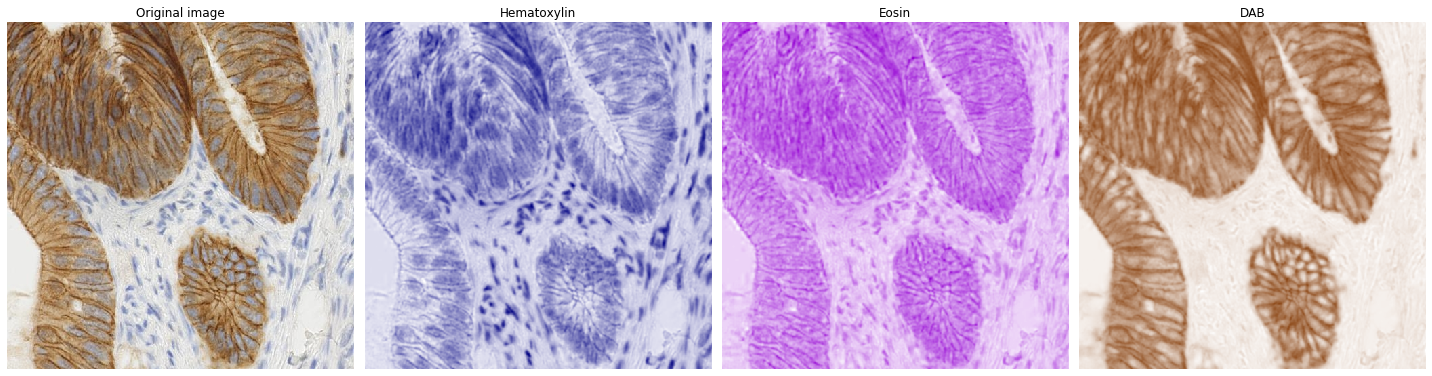

In [21]:
from skimage.color import separate_stains, hed_from_rgb
from matplotlib.colors import LinearSegmentedColormap

# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

smoothed = gaussian(rgb_image)

hed_image = separate_stains(smoothed, hed_from_rgb)

fig, axes = plt.subplots(1, 4, figsize=(20, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(rgb_image)
ax[0].set_title("Original image")

ax[1].imshow(hed_image[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")

ax[2].imshow(hed_image[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")

ax[3].imshow(hed_image[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

Here we can clearly see that we could use the DAB stain to segment the cellualr regions from this image. Have a go at implementing a pipeline of scikit image commands that could perform this segmentation on `dab_image` below.

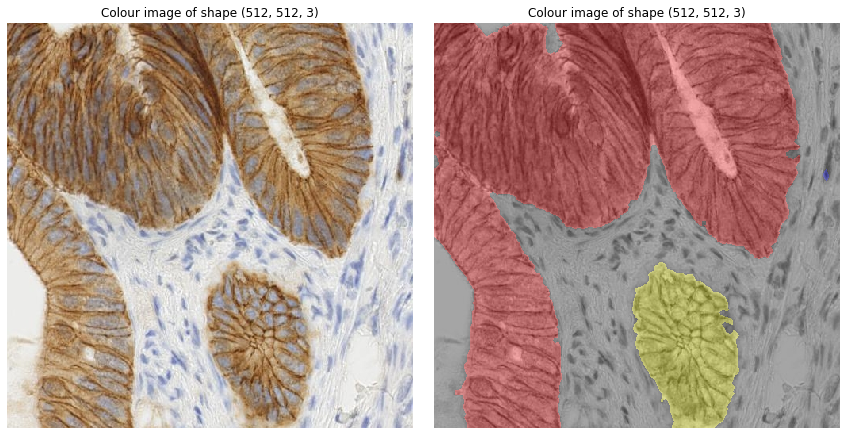

In [22]:
from skimage.filters import threshold_isodata

def get_labels(mask):
    
    # Again, we fill in any holes for each region we shall segment
    closed = binary_closing(thresholded, disk(3))

    filled = binary_fill_holes(closed)

    # label image regions
    label_image = label(filled)
    
    return label_image


# We use the channel that corresponds to the DAB color in our IHC stained image
dab_image = hed_image[:, :, 2]

# Here we threshold the image to remove the background
thresholded = dab_image > threshold_isodata(dab_image)

# label image regions
dab_label_image = get_labels(thresholded)

image_label_overlay = label2rgb(dab_label_image, image=grayscale, bg_label=0)

plot_image([rgb_image, image_label_overlay])

## Extension - GLCM Texture Analysis

More information about textures can be obtained using grey level co-occurence matricies (GLCM).

One way of desribing texture is in terms of co-occurence probablilities between intensity values in a region of pixels. A GLCM is a 4D array $P_{ijd\theta}$ describing the probability that, for a given pixel with an intensity value $i$ there exists another pixel with intensity $j$ at a distance $d$ away and oriented at an angle $\theta$. The scikit image fuction `skimage.feature.greycomatrix` can calculate the GLCM as a normalised histogram for a given 2D integer array in hexadecimal format (0-255 values). The range of distances and orientations are also required as input arguments.

Properties can be derived from these GLCMs that can be used as metrics for distinct textures. These include, for a given $d$ and $\theta$:

1) Contrast: $\sum_{i,j=0}^{levels-1} P_{i,j}(i-j)^2$

2) Dissimilarity: $\sum_{i,j=0}^{levels-1}P_{i,j}|i-j|$

3) Homogeneity: $\sum_{i,j=0}^{levels-1}\\frac{P_{i,j}}{1+(i-j)^2}$#

4) Energy: $\sqrt{\sum_{i,j=0}^{levels-1} P_{i,j}^2}$

5) Correlation:
    $\sum_{i,j=0}^{levels-1} P_{i,j}\left[\frac{(i-\mu_i)(j-\mu_j)}{\sqrt{(\sigma_i^2)(\sigma_j^2)}}\right]$

Typically these metrics are averaged over a range of local distances and orientations. In scikit-image, the function `skimage.feature.greycoprops` returns the values of these metrics for a given GLCM.


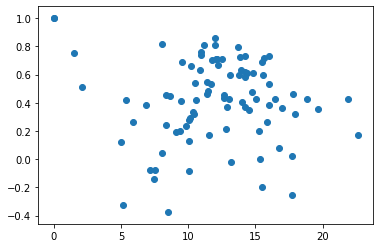

In [23]:
from skimage.feature import greycomatrix, greycoprops

regions = regionprops(label_image, intensity_image=grayscale)

# Construct a function that returns an GLCM for a given RegionProps instance.
# Experiment with calculating differen metrics from this GLCM using the greycoprops
# function

def region_glcm(region, distances, angles):
    """Returns a GLCM for the intensity image of a given RegionProps
    instance"""
    
    int_image = (region.intensity_image * 255).astype(int)
    glcm = greycomatrix(int_image, distances, angles, levels=256,
                        symmetric=True, normed=True)
    
    # Here we remove any probabiliies corresonding to ocurrences of pixels with
    # 0 as a value (artefacts introduced by our segmentation process)
    glcm[0, :, :, :] = 0
    glcm[:, 0, :, :] = 0
    
    return glcm

# compute some GLCM properties each patch
xs = []
ys = []
for region in regions:
    #xs.append(region.eccentricity)
    
    glcm = region_glcm(region, [1, 2], [0, np.pi/4, np.pi/2, np.pi*3/4])
    
    xs.append(greycoprops(glcm, 'dissimilarity').mean())
    ys.append(greycoprops(glcm, 'correlation').mean())
    
plt.scatter(xs, ys)
plt.show()

A further tutorial to using co-occurence patterns to measure texture properties can be found https://prism.ucalgary.ca/handle/1880/51900